## import dependencies

In [3]:
landlab.__version__

'2.2.0'

In [2]:
import os
import numpy as np
from landlab import RasterModelGrid
import landlab
from landlab.io import read_esri_ascii
from landlab.components import FlowAccumulator, FastscapeEroder, SedDepEroder,LinearDiffuser, ErosionDeposition, DepressionFinderAndRouter
from landlab.io.esri_ascii import write_esri_ascii

In [15]:
def create_folder(name):
    parent_folder = "./save_asc"
    path = os.path.join(parent_folder, name)
    if not os.path.exists(path):
        os.mkdir(path)  

In [2]:
#create_folder("")

## import DEM

In [38]:
(mg, z) = read_esri_ascii("./bacia_piratini_90m.asc", name="topographic__elevation")
mg.at_node.keys()

['topographic__elevation']

In [39]:
mg

RasterModelGrid((987, 1267), xy_spacing=(0.90000000000000002, 0.90000000000000002), xy_of_lower_left=(0.0, 0.0))

In [15]:
mg.number_of_node_columns, mg.number_of_nodes, mg.number_of_links

(1267, 1250529, 2498804)

In [15]:
mg.BC_LINK_IS_FIXED
#mg.set_fixed_value_boundaries_at_grid_edges(right, top, left, bottom)
mg.set_fixed_value_boundaries_at_grid_edges(True, True, True, True)

In [18]:
mg.number_of_links * 90

112446180.0

In [36]:
mg1 = RasterModelGrid((10, 40), 2.)
z = mg1.add_zeros("elevation", at="node")

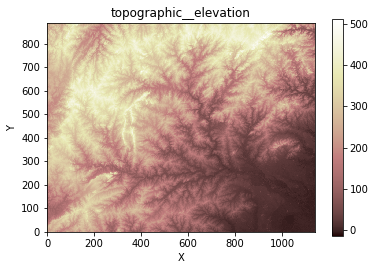

In [40]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation') 

In [17]:
#condiçoes de contorno
#mg.set_status_at_node_on_edges(right= mg.BC_NODE_IS_FIXED_VALUE, top=mg.BC_NODE_IS_FIXED_VALUE,
                               #left=mg.BC_NODE_IS_FIXED_VALUE, bottom=mg.BC_NODE_IS_FIXED_VALUE)
mg.set_status_at_node_on_edges(right= mg.BC_NODE_IS_FIXED_VALUE, top=mg.BC_NODE_IS_FIXED_VALUE,
                               left=mg.BC_NODE_IS_FIXED_VALUE, bottom=mg.BC_NODE_IS_FIXED_VALUE) 

In [18]:
mg.BC_NODE_IS_FIXED_VALUE

<NodeStatus.FIXED_VALUE: 1>

In [19]:
def return_grid():
    grid = mg.at_node['topographic__elevation'].reshape(400, 400)
    return grid
return_grid()

ValueError: cannot reshape array of size 1250529 into shape (400,400)

In [ ]:
def apply_boundary(boundary):
    grid = mg.at_node['topographic__elevation'].reshape(400, 400)
    grid[0] = mg.BC_NODE_IS_FIXED_VALUE
    grid[-1] = mg.BC_NODE_IS_FIXED_VALUE
    grid[:,][0] = mg.BC_NODE_IS_FIXED_VALUE
    return grid

apply_boundary(mg.BC_NODE_IS_FIXED_VALUE)

## creating component

In [25]:
#recebe o input do usuario
fr = FlowAccumulator(mg, flow_director='D8') 
df = DepressionFinderAndRouter(mg)
# m in the stream power equation (power on drainage area).
sp = FastscapeEroder(mg, K_sp=0.0004, m_sp=0.5, n_sp=1.0, threshold_sp= 0.0) #k eh erodibilidade, usar 0.0004
##FastscapeEroder(grid, K_sp=0.001, m_sp=0.5, n_sp=1.0, threshold_sp=0.0, discharge_field='drainage_area', erode_flooded_nodes=True)
mg.at_node['topographic__elevation'][0] -= 0.2 #uplift, valor inicial era 0.001 taxa 
sd= SedDepEroder(mg)
ed = ErosionDeposition(
     mg,
     K=0.004, # Erodibility for substrate (units vary). talvez a mesma do fast scape (valor anterior = 0.00001)
     v_s=0.001, # Effective settling velocity for chosen grain size metric [L/T].
     m_sp=0.5, # Discharge exponent (units vary) usar valores do fast scape (valor anterior = 0.5)
     n_sp = 1, #Slope exponent (units vary) usar valores do fast scape
     sp_crit=0) #Critical stream power to erode substrate [E/(TL^2)] usar valores do fast scape
#lin_diffuse = LinearDiffuser (mg, linear_diffusivity = 0.01)


In [26]:
mg.at_node.keys()

['topographic__elevation',
 'water__unit_flux_in',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope',
 'depression__depth',
 'depression__outlet_node',
 'is_pit',
 'flood_status_code',
 'channel__bed_shear_stress',
 'channel__discharge',
 'channel_sediment__relative_flux',
 'channel_sediment__volumetric_flux',
 'channel_sediment__volumetric_transport_capacity',
 'sediment__flux']

### run components

In [27]:
# Create test folder name
test_name = 'erosion_deposition_uplift_0,001_18_8'
create_folder(test_name)

NameError: name 'create_folder' is not defined

In [34]:
uplift_rate = 0.001
time_step = 1000 #time step linear diffuser component
#fr.run_one_step()
# sp.run_one_step(time_step) # atençao: apenas para rodar antes do erosion deposition
for i in range(10):
    print(i)
    fr.run_one_step()
    sp.run_one_step(time_step) #dt eh multiplicador da formula e do threshold,
    #df.map_depressions()
    flooded = np.where(df.flood_status==3)[0] # ver pra que serve
#     ed.run_one_step(time_step)
    mg.at_node['topographic__elevation'] += time_step * uplift_rate
    #no artigo ele usa em anos mas esta de acordo com todos os outros parametros em anos tbm 
    #lin_diffuse.run_one_step(time_step) 
#     if i ==1000  or i == 2000 or i == 4000 or i == 6000 or i == 8000 or i == 10000:
#         files = write_esri_ascii("./save_asc/"+test_name+"/"+str(i)+".asc", mg)


0
1
2
3
4
5
6
7
8
9


In [35]:
mg.at_node.keys()

['topographic__elevation',
 'water__unit_flux_in',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope',
 'depression__depth',
 'depression__outlet_node',
 'is_pit',
 'flood_status_code',
 'channel__bed_shear_stress',
 'channel__discharge',
 'channel_sediment__relative_flux',
 'channel_sediment__volumetric_flux',
 'channel_sediment__volumetric_transport_capacity',
 'sediment__flux']

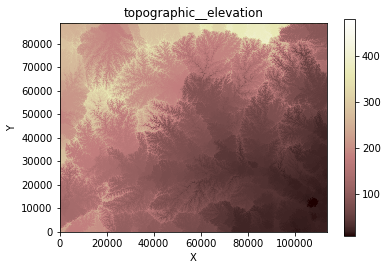

In [36]:
landlab.plot.imshow.imshow_grid_at_node(mg,'topographic__elevation')

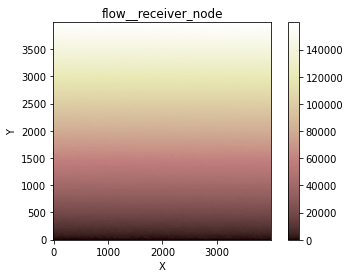

In [45]:
landlab.plot.imshow.imshow_grid_at_node(mg,'flow__receiver_node')

In [34]:
all(mg.at_node['drainage_area'] == mg.at_node['surface_water__discharge'])

True

In [37]:
grid = mg
_topographic__elevation = grid.at_node["topographic__elevation"]
_slope = grid.at_node["topographic__steepest_slope"]
_flow_receivers = grid.at_node["flow__receiver_node"]
_link_to_reciever = grid.at_node["flow__link_to_receiver_node"]

_link_lengths = grid.length_of_d8

In [51]:
len(_link_lengths)

637602

In [38]:
_topographic__elevation

array([ 1.8,  2. ,  2. , ...,  2. ,  2. ,  2. ])

In [43]:
_flow_receivers

array([     0,      1,      2, ..., 159997, 159998, 159999])

In [49]:
arr =_topographic__elevation - _topographic__elevation[_flow_receivers]
arr[arr > 0]

152254

In [66]:
_slope[:] = (
            _topographic__elevation
            - _topographic__elevation[_flow_receivers]
        ) / _link_lengths[_link_to_reciever]

In [72]:
_q = grid.at_node["surface_water__discharge"]
_Q_to_the_m = np.zeros(grid.number_of_nodes)
_Q_to_the_m[:] = np.power(_q, 0.5)
erosion = 0.0004 * _Q_to_the_m * np.power(_slope, 2)
erosion

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [75]:
omega_over_sp_crit = np.divide(
            erosion, 0, out=np.zeros_like(erosion), where=0 != 0)

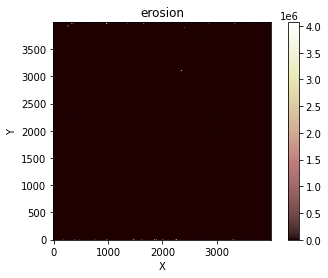

In [73]:
mg.add_field("erosion", erosion, at="node", copy=True, clobber=False)
landlab.plot.imshow.imshow_grid_at_node(mg,'erosion')

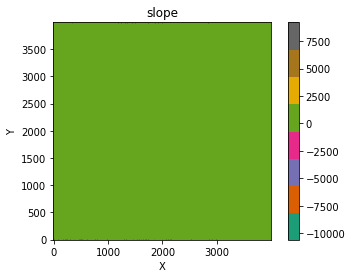

In [87]:
# mg.add_field("slope", _slope, at="node", copy=True, clobber=False)
landlab.plot.imshow.imshow_grid_at_node(mg,'slope', cmap="Dark2")

In [99]:
grid = mg.at_node['topographic__elevation']
grid[grid< 0]
neg = list(filter(lambda x: x[1] < 0,enumerate(grid)))
neg

[(401, -7329.0439339125232),
 (402, -9102.8892093071299),
 (403, -7613.1871899284879),
 (404, -6790.8247946575111),
 (405, -6357.47952047952),
 (406, -6286.9611499611501),
 (407, -6190.6612589532078),
 (408, -6992.0740486479272),
 (409, -8217.8034725946982),
 (410, -8098.8008024426972),
 (411, -6474.2541127694294),
 (412, -5645.0769230769238),
 (413, -5606.7869517999698),
 (414, -5615.0619380619364),
 (415, -6594.7324738355464),
 (416, -7625.1568751656914),
 (417, -5854.1100419697032),
 (418, -11594.438494913091),
 (419, -28283.838928000008),
 (420, -11634.634013680035),
 (421, -6373.6001431949044),
 (422, -9515.0130885947492),
 (423, -8730.1261442159648),
 (424, -8131.7817393051073),
 (425, -7172.9616171647849),
 (426, -10461.816709027789),
 (427, -9692.0362212748514),
 (428, -7898.2575579586455),
 (429, -6833.0939702818541),
 (430, -6293.8531468531482),
 (431, -9324.3215017065286),
 (432, -17372.89498624258),
 (433, -13390.48034673234),
 (434, -10645.921466052814),
 (435, -8768.75418

In [18]:
files = write_esri_ascii("./save_asc/ascii_fse_2.asc", mg) #salva DEM no formato ASCII, salva um arquivo por grid


In [20]:
(mg1, z) = read_esri_ascii("./save_asc/ascii_fse_1_topographic__elevation.asc", name="topographic__elevation")
mg1.at_node.keys()

['topographic__elevation']

In [21]:
landlab.plot.imshow.imshow_grid_at_node(mg1,'topographic__elevation') #range 5

NameError: name 'mg1' is not defined

In [37]:
(mg5, z) = read_esri_ascii("./save_asc/ascii_fse_30_topographic__steepest_slope.asc", name="topographic__elevation")
mg5.at_node.keys()

['topographic__elevation']

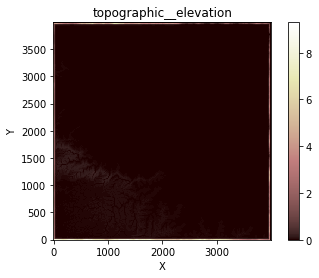

In [38]:
landlab.plot.imshow.imshow_grid_at_node(mg5,'topographic__elevation') #range 30